## DE analysis TECs and FBs: steroid synthesis and modification and TEC-DE genes

In [1]:
import os
import sys
from datetime import datetime
today = datetime.today().strftime('%Y-%m-%d')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as ad
import hdf5plugin

# Add repo path to sys path (allows to access scripts and metadata from repo)
repo_path = '/nfs/team205/vk8/projects/thymus_ageing_atlas/TEC_compartment'
sys.path.insert(1, repo_path) 
sys.path.insert(2, '/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts')


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to show output from all the lines in a cells
pd.set_option('display.max_column',None) # display all the columns in pandas
pd.options.display.max_rows = 100

In [2]:
# Define plot and path dirs
plot_path = os.path.join(repo_path, 'plots')
data_path = os.path.join(repo_path, 'data')
model_path = os.path.join(repo_path, 'models')
# Define plot and path dirs
results_path = os.path.join(repo_path, 'results')
general_data_path = '/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/data'

In [3]:
# Formatting
from matplotlib import font_manager
font_manager.fontManager.addfont("/nfs/team205/ny1/ThymusSpatialAtlas/software/Arial.ttf")
#plt.style.use('/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/thyAgeing.mplstyle')


In [4]:
# Import custom scripts
from utils import get_latest_version,update_obs,freq_by_donor
from anno_levels import get_ct_levels, get_ct_palette, age_group_levels, age_group_palette
from plotting.utils import plot_grouped_boxplot, calc_figsize
from plotting.colors import thyAgeing_colors

In [5]:
plt.style.use('/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/thyAgeing.mplstyle')

## Load adata

In [6]:
# Load adata
object_version = 'v5_2025-04-03'
adata = ad.read_h5ad(f'{general_data_path}/objects/rna/thyAgeing_all_scvi_{object_version}.zarr')
# Add final annotations to adata and remove non-annotated cells
ct_anno = pd.read_csv(f'{general_data_path}/objects/rna/thyAgeing_all_scvi_v5_2025-10-15_curatedAnno_v11.csv', index_col = 0)

for c in ct_anno.columns:
    if c in adata.obs.columns:
        adata.obs.drop(c, axis = 1, inplace = True)
adata.obs = adata.obs.join(ct_anno)

adata = adata[~adata.obs['taa_l5'].isnull(),].copy()
# Update metadata
latest_meta_path = get_latest_version(dir = f'{general_data_path}/metadata', file_prefix='Thymus_ageing_metadata')
latest_meta = pd.read_excel(latest_meta_path)

update_obs(adata, latest_meta, on = 'index')


Latest file: Thymus_ageing_metadata_v28_2025-03-13.xlsx
No columns specified to update. Automatically determining columns to update...
Updating columns: ['age', 'age_cont', 'age_group', 'age_group2', 'age_months', 'age_num', 'age_unit', 'chemistry_detail', 'chemistry_orig', 'chemistry_simple', 'cite', 'comment', 'donor', 'health_status', 'in_HTSA', 'library', 'library_bcr', 'library_tcr_ab', 'library_tcr_gd', 'origin_institute', 'path_bcr', 'path_cellbender_gex', 'path_cellranger_arc', 'path_raw_gex', 'path_tcr_ab', 'path_tcr_gd', 'public_data', 'research_no', 'sample', 'sex', 'sort', 'sort_type', 'starsolo_version', 'study', 'type']
On columns: index


## Load DE results

In [8]:
## Load all DE results level 4 (adult vs infant)
import pickle as pkl
with open(f'{general_data_path}/analyses/dea/thyAgeing_dea_taa_l4_adult_vs_infant_ageEffect.pkl', 'rb') as f:
    de_ad2inf_lev4_dict = pkl.load(f)

de_ad2inf_lev4 = pd.concat([v for k,v in de_ad2inf_lev4_dict.items()], keys = de_ad2inf_lev4_dict.keys(), names = ['cell_type']).reset_index().rename(columns = {'level_1':'gene_name'})
## Load DE results for priming (adult vs infant)
with open(f'{results_path}/thyAgeing_TEC_dea_4cnts_TECpri_annos.pkl', 'rb') as de_pri:
    de_res_dict_pri = pkl.load(de_pri)
    
de_df_pri = pd.concat([v for k,v in de_res_dict_pri['de_df'].items() if k in ['cTEC-pri:adult-vs-infant', 'unpri:adult-vs-infant',
                                                    'mTEC-pri:adult-vs-infant']], 
           keys = ['cTEC-pri:adult-vs-infant', 'unpri:adult-vs-infant','mTEC-pri:adult-vs-infant'], 
           names = ['cell_type:cont']).reset_index().rename(columns = {'level_1':'gene_name'})
de_df_pri[['cell_type', 'cont']] = de_df_pri['cell_type:cont'].str.split(':', expand = True)
de_ad2inf_lev4_pri = pd.concat([de_ad2inf_lev4, de_df_pri])

de_ad2inf_lev4_pri['contrast'] = 'adult-vs-infant'
de_ad2inf_lev4_pri['change'] = de_ad2inf_lev4_pri.apply(lambda x: 'sign_up' if (x['padj'] <0.05) & (x['log2FoldChange'] >0) else
                               'sign_dw' if (x['padj'] <0.05) & (x['log2FoldChange'] < 0) else
                                'non_sign', axis = 1)

In [9]:
## Load all DE results level 3 (adult vs infant)
with open(f'{general_data_path}/analyses/dea/thyAgeing_dea_taa_l3_adult_vs_infant_ageEffect.pkl', 'rb') as f:
    de_ad2inf_lev3_dict = pkl.load(f)

de_ad2inf_lev3 = pd.concat([v for k,v in de_ad2inf_lev3_dict.items()], keys = de_ad2inf_lev3_dict.keys(), names = ['cell_type']).reset_index().rename(columns = {'level_1':'gene_name'})


with open(f'{general_data_path}/analyses/dea/thyAgeing_dea_taa_l3_paed_vs_infant_ageEffect.pkl', 'rb') as f:
    de_paed2inf_lev3_dict = pkl.load(f)

de_paed2inf_lev3 = pd.concat([v for k,v in de_paed2inf_lev3_dict.items()], keys = de_paed2inf_lev3_dict.keys(), names = ['cell_type']).reset_index().rename(columns = {'level_1':'gene_name'})


In [10]:
for df in [de_ad2inf_lev4, de_ad2inf_lev3, de_paed2inf_lev3, de_df_pri]:
    df['change'] = df.apply(lambda x: 'sign_up' if (x['padj'] <0.05) & (x['log2FoldChange'] >0) else
                               'sign_dw' if (x['padj'] <0.05) & (x['log2FoldChange'] < 0) else
                                'non_sign', axis = 1)

In [11]:
de_ad2inf_lev3['contrast'] = 'adult-vs-infant'
de_paed2inf_lev3['contrast'] = 'paed-vs-infant'
de_ad2inf_lev3['col_cell_type'] = 'taa_l3'

## Plot DE results (General settings)

from plotting.utils import thyAgeing_colors
from matplotlib import colors as mcolors

max_abs = np.abs(df_median['logFC']).max()
vmin, vmax, vcenter = -max_abs, max_abs, 0
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
cmap = sns.blend_palette([thyAgeing_colors['teal'], 'white', thyAgeing_colors['orange']], as_cmap=True)

In [6]:
from plotting.utils import thyAgeing_colors
from matplotlib import colors as mcolors
def plot_de_dotplot2(
    adata_input, deseq_df, ctype_col, 
    ctype_lev, contrast, 
    ctypes,
    genes,
    cmap_new = None,
    cbar_title = 'log2FC',
    dsize_title = 'Fraction of expressing cells',
    formating = 'totals',
    swap = False,
    save_path=None,**kwargs
):
    if ctype_lev and contrast:
        subset_df = deseq_df.loc[(deseq_df['gene_name'].isin(genes)) & (deseq_df[ctype_col].isin(ctypes)) & (deseq_df['col_cell_type']==ctype_lev) & (deseq_df['contrast']==contrast),].pivot(index = ctype_col, columns = 'gene_name')
    else:
        subset_df = deseq_df.loc[(deseq_df['gene_name'].isin(genes)) & (deseq_df[ctype_col].isin(ctypes)) ,].pivot(index = ctype_col, columns = 'gene_name')
    ctypes_overvwrite = [i for i in ctypes if i in subset_df.index.tolist()]
    print(f'Celltypes {np.setdiff1d(np.array(ctypes), np.array(ctypes_overvwrite))} are missing')
    adata_subset = adata_input[(adata_input.obs[ctype_lev].isin(ctypes_overvwrite)),].copy()
   #print(subset_df['log2FoldChange'].columns.tolist())
    genes_overwrite = [gene for gene in genes if gene in subset_df['log2FoldChange'].columns.tolist()]
    print(genes_overwrite)
    lfc_df = subset_df['log2FoldChange'].loc[ctypes_overvwrite, genes_overwrite].copy()
   # print(lfc_df)
    lfc_df = lfc_df.fillna(0)
   # print(lfc_df)
    sign_df = subset_df['change'].loc[ctypes_overvwrite, genes_overwrite].copy()
    sign_df = sign_df.fillna(1)
   # print(lfc_df)
   #print(sign_df)
   #print(sign_df.values.flatten())
  #  vmin, vmax, vcenter = -4.5, 4.5, 0
  #  normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
    if cmap_new is None:
        cmap_new = sns.blend_palette([thyAgeing_colors['teal'], 'white', thyAgeing_colors['orange']], as_cmap=True)
    if swap:
        edge_colors = [thyAgeing_colors['orange'] if sig == 'sign_up' else thyAgeing_colors['teal'] if sig == 'sign_dw' else 'lightgray' for sig in sign_df.T.values.flatten()]
        dp = sc.pl.dotplot(adata_subset, var_names = genes_overwrite, groupby = ctype_lev,
             dot_color_df = lfc_df, categories_order = ctypes_overvwrite, cmap = cmap_new, vcenter = 0, vmin=-4.5, vmax =4.5, 
             edgecolor=edge_colors, colorbar_title=cbar_title,linewidth = 0.3, size_title = dsize_title,
             return_fig = True, swap_axes=True, dot_max=1, **kwargs)
    else:
        edge_colors = [thyAgeing_colors['orange'] if sig == 'sign_up' else thyAgeing_colors['teal'] if sig == 'sign_dw' else 'lightgray' for sig in sign_df.values.flatten()]
       # edge_colors = ['red' if sig in ['sign_up', 'sign_dw', 'sign_lo'] else 'black' for sig in sign_df.values.flatten()]
        dp = sc.pl.dotplot(adata_subset, var_names = genes_overwrite, groupby = ctype_lev,
             dot_color_df = lfc_df, categories_order = ctypes_overvwrite, cmap = cmap_new, vcenter = 0, vmin=-4.5, vmax =4.5, 
             edgecolor=edge_colors, colorbar_title=cbar_title,linewidth = 0.3, size_title = dsize_title,
             return_fig = True,dot_max=1, **kwargs)
    dp = dp.style(smallest_dot=0, largest_dot = 100)
    if formating == 'totals':
        dp = dp.add_totals(size = 0.5)
    if save_path:
        dp.savefig(save_path, bbox_inches='tight')
    return (dp)
    #dp.show()

In [14]:
tec_pri_levels = ['cTECIII','cTECII','cTECI', 'cTEC-pri', 'unpri', 'mTEC-pri','mTECI', 'mTECII', 'mTECIII']
tec_levels = ['cTEC', 'mcTEC','mTECI', 'mTECII', 'mTECIII']

In [8]:
tec_lev3 = get_ct_levels(level = 'taa_l3', taa_l1='TEC')
tec_lev4 = get_ct_levels(level = 'taa_l4', taa_l1='TEC')

Latest file: thyAgeing_full_curatedAnno_v11_2025-08-29_levels.xlsx
Latest file: thyAgeing_full_curatedAnno_v11_2025-08-29_levels.xlsx


In [9]:
stroma_lev3 = get_ct_levels(level = 'taa_l3', taa_l1= ['Fb', 'EC','Mural',])
stroma_lev4 = get_ct_levels(level = 'taa_l4', taa_l1= ['Fb','EC','Mural',])

Latest file: thyAgeing_full_curatedAnno_v11_2025-08-29_levels.xlsx
Latest file: thyAgeing_full_curatedAnno_v11_2025-08-29_levels.xlsx


In [17]:
ctypes_lev3 = get_ct_levels(level = 'taa_l3')

Latest file: thyAgeing_full_curatedAnno_v11_2025-08-29_levels.xlsx


## Load gene sets

In [56]:
down_tec_lst = ['FOXN1', 'CXCL12', 'CCL25', 'DLL4','PSMB11', 'PRSS16',
               'AIRE', 'FEZF2', 'GHRL', 'EMX1', 'KRT72', 'AVP', 'GNGT1']

In [47]:
steroid_tecs = {
    'steroid activation':['AKR1C3', 'HSD17B7'],
    'steroid inactivation': ['AKR1C1','AKR1C2', 'HSD17B2', 'HSD17B11'], 
    'conjugation for export': ['SULT1A1', 'SULT1E1', 'UGT2B7'],
    'steroid receptors': ['AR','FKBP5', 'ZBTB16', 'SGK1',  "ESR1", "ESR2", "PGR"],
}

In [49]:
mc_tec_survival_lst = ['IGF1R', 'IGF2R',"IGFBP1","IGFBP2","IGFBP3","IGFBP4","IGFBP5","IGFBP6","IGFBP7", "CCN1", "CCN2", 
'PPARG', 'PPARGC1A', 'PLIN5', 'COL3A1', 'COL6A3', 'COL14A1','ISG15', 'IRF8', 'IFIT1', 'IFIT2', 'IFIT3']

In [48]:
adipose_transf = {
   # 'general synthesis': ['STAR', 'CYP5A', 'POR'],
    'gc': ['HSD11B1', 'HSD11B2', 'NR3C1'],
    'steroid activation':['AKR1C3', 'HSD17B7'],
    'steroid inactivation': ['AKR1C1','AKR1C2', 'HSD17B4', 'HSD17B14'], 
    'steroid receptors':['AR','FKBP5', 'ZBTB16', 'SGK1',  "ESR1", "ESR2", "PGR", ],
    'growth-factors': ['IGF1']
}

In [50]:
steroid_tecs_lst = [gene for genes in steroid_tecs.values() for gene in genes]

In [51]:
adipose_transf_lst = [gene for genes in adipose_transf.values() for gene in genes]

## Plot TEC DE genes

Celltypes [] are missing
['FOXN1', 'CXCL12', 'CCL25', 'DLL4', 'PSMB11', 'PRSS16', 'AIRE', 'FEZF2', 'GHRL', 'EMX1', 'KRT72', 'AVP', 'GNGT1']


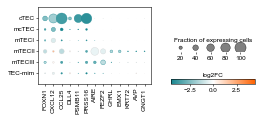

In [59]:
plot_de_dotplot2 (
    adata_input = adata, 
    deseq_df = de_ad2inf_lev3, 
    ctype_col = 'cell_type', 
    ctype_lev = 'taa_l3',
    contrast=None,
    ctypes = ['cTEC', 'mcTEC', 'mTECI', 'mTECII', 'mTECIII', 'TEC-mim'],
    genes = down_tec_lst,
    cbar_title = 'log2FC',
    dsize_title = 'Fraction of expressing cells',
    swap = False, figsize = (3.5, 1.2), formating = '',
    save_path=f'{plot_path}/de_dotplot_TEC_downDE_adult_vs_infant_{today}.pdf'
)

Celltypes [] are missing
['AKR1C3', 'HSD17B7', 'AKR1C1', 'AKR1C2', 'HSD17B2', 'HSD17B11', 'SULT1A1', 'SULT1E1', 'UGT2B7', 'AR', 'FKBP5', 'ZBTB16', 'SGK1', 'ESR1', 'ESR2', 'PGR']


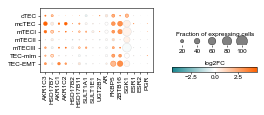

In [27]:
plot_de_dotplot2 (
    adata_input = adata, 
    deseq_df = de_ad2inf_lev3, 
    ctype_col = 'cell_type', 
    ctype_lev = 'taa_l3',
    contrast=None,
    ctypes = tec_lev3,
    genes = steroid_tecs_lst,
    cbar_title = 'log2FC',
    dsize_title = 'Fraction of expressing cells',
    swap = False, figsize = (3.5, 1.0), formating = '', 
    save_path=f'{plot_path}/de_dotplot_steroid_TECs_l3_adult_vs_infant_{today}.pdf'
)

Celltypes [] are missing
['AKR1C3', 'HSD17B7', 'AKR1C1', 'AKR1C2', 'HSD17B2', 'HSD17B11', 'SULT1A1', 'SULT1E1', 'UGT2B7', 'AR', 'FKBP5', 'ZBTB16', 'SGK1', 'ESR1', 'ESR2', 'PGR']


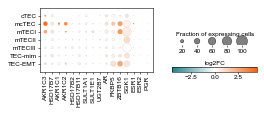

In [52]:
plot_de_dotplot2 (
    adata_input = adata, 
    deseq_df = de_paed2inf_lev3, 
    ctype_col = 'cell_type', 
    ctype_lev = 'taa_l3',
    contrast=None,
    ctypes = tec_lev3,
    genes = steroid_tecs_lst,
    cbar_title = 'log2FC',
    dsize_title = 'Fraction of expressing cells',
    swap = False, figsize = (3.5, 1.0), formating = '', 
    save_path=f'{plot_path}/de_dotplot_steroid_TECs_l3_lpaed_vs_infant_{today}.pdf'
)

Celltypes [] are missing
['IGF1R', 'IGF2R', 'IGFBP1', 'IGFBP2', 'IGFBP3', 'IGFBP4', 'IGFBP5', 'IGFBP6', 'IGFBP7', 'CCN1', 'CCN2', 'PPARG', 'PPARGC1A', 'PLIN5', 'COL3A1', 'COL6A3', 'COL14A1', 'ISG15', 'IRF8', 'IFIT1', 'IFIT2', 'IFIT3']


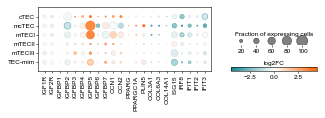

In [61]:
plot_de_dotplot2 (
    adata_input = adata, 
    deseq_df = de_ad2inf_lev3, 
    ctype_col = 'cell_type', 
    ctype_lev = 'taa_l3',
    contrast=None,
    ctypes = ['cTEC', 'mcTEC', 'mTECI', 'mTECII', 'mTECIII', 'TEC-mim'],
    genes = mc_tec_survival_lst,
    cbar_title = 'log2FC',
    dsize_title = 'Fraction of expressing cells',
    swap = False, figsize = (4.5, 1.0), formating = '',
    save_path=f'{plot_path}/de_dotplot_mcTEC_DE_adult_vs_infant_{today}.pdf'
)

## Plot Fb/Stroma DE genes

Celltypes ['EC-peri' 'Fb-interm'] are missing
['HSD11B1', 'HSD11B2', 'NR3C1', 'AKR1C3', 'HSD17B7', 'AKR1C1', 'AKR1C2', 'HSD17B4', 'HSD17B14', 'AR', 'FKBP5', 'ZBTB16', 'SGK1', 'ESR1', 'ESR2', 'PGR', 'IGF1']


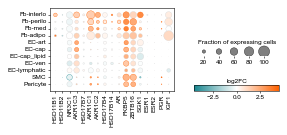

In [28]:
plot_de_dotplot2 (
    adata_input = adata, 
    deseq_df = de_ad2inf_lev3, 
    ctype_col = 'cell_type', 
    ctype_lev = 'taa_l3',
    contrast=None,
    ctypes = stroma_lev3,
    genes = adipose_transf_lst,
    cbar_title = 'log2FC',
    dsize_title = 'Fraction of expressing cells',
    swap = False, figsize = (3.7, 1.3), formating = '',
    save_path=f'{plot_path}/de_dotplot_Adipose_transfo_Stroma_l3_adult_vs_infant_{today}.pdf'
)

Celltypes ['EC-cap_lipid' 'EC-lymphatic' 'EC-peri' 'Fb-adipo' 'Fb-interm'] are missing
['HSD11B1', 'HSD11B2', 'NR3C1', 'AKR1C3', 'HSD17B7', 'AKR1C1', 'AKR1C2', 'HSD17B4', 'HSD17B14', 'AR', 'FKBP5', 'ZBTB16', 'SGK1', 'ESR1', 'ESR2', 'PGR', 'IGF1']


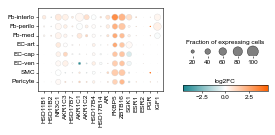

In [60]:
plot_de_dotplot2 (
    adata_input = adata, 
    deseq_df = de_paed2inf_lev3, 
    ctype_col = 'cell_type', 
    ctype_lev = 'taa_l3',
    contrast=None,
    ctypes = stroma_lev3,
    genes = adipose_transf_lst,
    cbar_title = 'log2FC',
    dsize_title = 'Fraction of expressing cells',
    swap = False, figsize = (3.7, 1.3), formating = '',
    save_path=f'{plot_path}/de_dotplot_Adipose_transfo_Stroma_l3_paed_vs_infant_{today}.pdf'
)

## ** Check gender effect for DE genes

### Adult-vs-infant gender effect

In [27]:
## Load aged vs adult (sex effect) DE results (level 3)
import pickle
# Load aged vs adult (sex effect) DE results (level 3)
with open('/nfs/team205/lm25/thymus_projects/thymus_ageing_atlas/General_analysis/data/analyses/dea/thyAgeing_dea_taa_l3_adult_vs_infant_sexEffect.pkl', 'rb') as f:
    deg = pickle.load(f)

deg = pd.concat(
    [v for k, v in deg.items()],
    keys = deg.keys(),
    names = ['cell_type']
).reset_index().rename(columns = {'level_1':'gene_name'})

# Add metadata columns consistent with other DE dataframes
deg['contrast'] = 'adult-vs-infant'
deg['change'] = deg.apply(
    lambda x: 'sign_up' if (x['padj'] < 0.05) & (x['log2FoldChange'] > 0) else
              'sign_dw' if (x['padj'] < 0.05) & (x['log2FoldChange'] < 0) else
              'non_sign', axis=1
)

In [10]:
steroid_tecs = {
    'steroid activation':['AKR1C3', 'HSD17B7'],
    'steroid inactivation': ['AKR1C1','AKR1C2', 'HSD17B2', 'HSD17B11'],
    'conjugation for export': ['SULT1A1', 'SULT1E1', 'UGT2B7'],
    'steroid receptors': ['AR','FKBP5', 'ZBTB16', 'SGK1',  "ESR1", "ESR2", "PGR"],
}
steroid_tecs_lst = [gene for genes in steroid_tecs.values() for gene in genes]

steroid_fbs = {
    'gc': ['HSD11B1', 'HSD11B2', 'NR3C1'],
    'steroid activation':['AKR1C3', 'HSD17B7'],
    'steroid inactivation': ['AKR1C1','AKR1C2', 'HSD17B4', 'HSD17B14'], 
    'steroid receptors':['AR','FKBP5', 'ZBTB16', 'SGK1',  "ESR1", "ESR2", "PGR", ]
}
steroid_fbs_lst = [gene for genes in steroid_fbs.values() for gene in genes]

In [29]:
deg_tec = deg[(deg['cell_type'].isin(tec_lev4)) & (deg['gene_name'].isin(steroid_tecs_lst))]
deg_fbs = deg[(deg['cell_type'].isin(stroma_lev4)) & (deg['gene_name'].isin(steroid_fbs_lst))]
deg_tec

,cell_type,gene_name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,contrast,change
359432,TEC-EMT,HSD17B7,10.759252,-0.557223,0.378734,-1.471277,0.141216,0.998856,adult-vs-infant,non_sign
362297,TEC-EMT,UGT2B7,0.613842,-0.669063,1.249189,-0.535598,0.592237,0.998856,adult-vs-infant,non_sign
362299,TEC-EMT,SULT1E1,1.986118,-0.353223,0.794596,-0.444531,0.656659,0.998856,adult-vs-infant,non_sign
362399,TEC-EMT,HSD17B11,12.123555,-0.049803,0.454097,-0.109674,0.912668,0.998856,adult-vs-infant,non_sign
363883,TEC-EMT,FKBP5,32.171673,-0.030942,0.597134,-0.051817,0.958674,0.998856,adult-vs-infant,non_sign
...,...,...,...,...,...,...,...,...,...,...
749963,mcTEC,ZBTB16,132.258448,-0.441794,0.621279,-0.711104,0.477020,0.954799,adult-vs-infant,non_sign
752084,mcTEC,ESR2,0.238968,-0.020329,1.048828,-0.019382,0.984536,0.999021,adult-vs-infant,non_sign
753641,mcTEC,SULT1A1,28.536034,-0.001857,0.256010,-0.007255,0.994211,0.999178,adult-vs-infant,non_sign
754138,mcTEC,HSD17B2,3.016539,0.992800,0.713410,1.391625,0.164036,0.731212,adult-vs-infant,non_sign


Celltypes ['TEC-cilliated' 'TEC-iono' 'TEC-myo' 'TEC-neuro' 'TEC-tuft' 'cTECI'
 'cTECII' 'cTECIII' 'mTECI-trans'] are missing
['HSD17B7', 'UGT2B7', 'SULT1E1', 'HSD17B11', 'FKBP5', 'SGK1', 'ESR1', 'AKR1C1', 'AKR1C2', 'AKR1C3', 'PGR', 'ZBTB16', 'ESR2', 'SULT1A1', 'HSD17B2', 'AR']


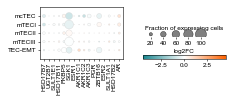

In [30]:
plot_de_dotplot2 (
    adata_input = adata, 
    deseq_df = deg_tec, 
    ctype_col = 'cell_type', 
    ctype_lev = 'taa_l4',
    contrast=None,
    ctypes = tec_lev4,
    genes = deg_tec['gene_name'].unique().tolist(),
    cbar_title = 'log2FC',
    dsize_title = 'Fraction of expressing cells',
    swap = False, figsize = (3, 0.8), formating = '',
    save_path=f'{plot_path}/de_dotplot_TEC_lev4_DE_Steroids_adult_vs_infant_gender_{today}.pdf'
)

Celltypes ['EC-peri' 'Fb-interlo_PI16' 'Fb-interm' 'Fb-perilo_COLEC11' 'Peri-cap'
 'Peri-smc-interm' 'SMC-art' 'SMC-ven'] are missing
['HSD17B7', 'FKBP5', 'SGK1', 'ESR1', 'AKR1C1', 'AKR1C2', 'AKR1C3', 'PGR', 'ZBTB16', 'ESR2', 'AR']


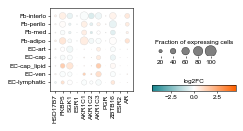

In [31]:
plot_de_dotplot2 (
    adata_input = adata, 
    deseq_df = deg_fbs, 
    ctype_col = 'cell_type', 
    ctype_lev = 'taa_l4',
    contrast=None,
    ctypes = stroma_lev4,
    genes = deg_tec['gene_name'].unique().tolist(),
    cbar_title = 'log2FC',
    dsize_title = 'Fraction of expressing cells',
    swap = False, figsize = (3, 1.3), formating = '',
    save_path=f'{plot_path}/de_dotplot_Stroma_lev4_DE_Steroids_adult_vs_infant_gender_{today}.pdf'
)

### Gender effect within adult

In [32]:
## Load aged vs adult (sex effect) DE results (level 3)
import pickle
# Load aged vs adult (sex effect) DE results (level 3)
with open('/nfs/team205/lm25/thymus_projects/thymus_ageing_atlas/General_analysis/data/analyses/dea/thyAgeing_dea_taa_l4_F_vs_M_genderEffect_adult.pkl', 'rb') as f:
    deg = pickle.load(f)

deg = pd.concat(
    [v for k, v in deg.items()],
    keys = deg.keys(),
    names = ['cell_type']
).reset_index().rename(columns = {'level_1':'gene_name'})

# Add metadata columns consistent with other DE dataframes
deg['contrast'] = 'adult-vs-infant'
deg['change'] = deg.apply(
    lambda x: 'sign_up' if (x['padj'] < 0.05) & (x['log2FoldChange'] > 0) else
              'sign_dw' if (x['padj'] < 0.05) & (x['log2FoldChange'] < 0) else
              'non_sign', axis=1
)

deg_tec = deg[(deg['cell_type'].isin(tec_lev4)) & (deg['gene_name'].isin(steroid_tecs_lst))]
deg_fbs = deg[(deg['cell_type'].isin(stroma_lev4)) & (deg['gene_name'].isin(steroid_fbs_lst))]

Celltypes ['TEC-cilliated' 'TEC-tuft' 'cTECI' 'cTECII' 'cTECIII' 'mTECII'] are missing
['HSD17B7', 'UGT2B7', 'SULT1E1', 'HSD17B11', 'FKBP5', 'SGK1', 'ESR1', 'AKR1C1', 'AKR1C2', 'AKR1C3', 'PGR', 'ZBTB16', 'SULT1A1', 'HSD17B2', 'AR', 'ESR2']


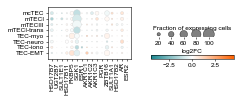

In [33]:
plot_de_dotplot2 (
    adata_input = adata, 
    deseq_df = deg_tec, 
    ctype_col = 'cell_type', 
    ctype_lev = 'taa_l4',
    contrast=None,
    ctypes = tec_lev4,
    genes = deg_tec['gene_name'].unique().tolist(),
    cbar_title = 'log2FC',
    dsize_title = 'Fraction of expressing cells',
    swap = False, figsize = (3, 0.8), formating = '',
    save_path=f'{plot_path}/de_dotplot_TEC_lev4_DE_Steroids_adult_gender_{today}.pdf'
)

In [34]:
plot_path

'/nfs/team205/vk8/projects/thymus_ageing_atlas/TEC_compartment/plots'

Celltypes ['EC-peri' 'SMC-ven'] are missing
['HSD17B7', 'FKBP5', 'SGK1', 'ESR1', 'AKR1C1', 'AKR1C2', 'AKR1C3', 'PGR', 'ZBTB16', 'AR', 'ESR2']


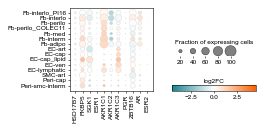

In [35]:
plot_de_dotplot2 (
    adata_input = adata, 
    deseq_df = deg_fbs, 
    ctype_col = 'cell_type', 
    ctype_lev = 'taa_l4',
    contrast=None,
    ctypes = stroma_lev4,
    genes = deg_tec['gene_name'].unique().tolist(),
    cbar_title = 'log2FC',
    dsize_title = 'Fraction of expressing cells',
    swap = False, figsize = (3, 1.3), formating = '',
    save_path=f'{plot_path}/de_dotplot_Stroma_lev4_DE_Steroids_adult_gender_{today}.pdf'
)